In [20]:
# 1. Install Dependencies
# We use Unsloth for the model, and specific libraries for metrics
!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q --no-deps xformers peft accelerate bitsandbytes triton
!pip install -q evaluate rouge_score sacrebleu bert_score scikit-learn seaborn matplotlib

import torch
print(f"GPU Available: {torch.cuda.is_available()}")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
GPU Available: True


In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from unsloth import FastVisionModel
import evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. DATASET PATHS ---
# Robust logic to find your nested dataset
def find_dataset_root():
    candidates = [
        "/kaggle/input/raf-au/RAF-AU",  # Nested structure
        "/kaggle/input/raf-au",         # Flat structure
        "/kaggle/input/RAF-AU/RAF-AU",
        "/kaggle/input/RAF-AU"
    ]
    for path in candidates:
        if os.path.exists(os.path.join(path, "aligned")):
            return path
    return "/kaggle/input/raf-au" # Fallback

ROOT_DIR = find_dataset_root()
DATA_DIR = os.path.join(ROOT_DIR, "aligned")
EMOLABEL_FILE = os.path.join(ROOT_DIR, "RAFCE_emolabel.txt")
PARTITION_FILE = os.path.join(ROOT_DIR, "RAFCE_partition.txt")
AU_FILE = os.path.join(ROOT_DIR, "RAFCE_AUlabel.txt")

print(f"📂 Dataset Root: {ROOT_DIR}")
print(f"📂 Images Dir: {DATA_DIR}")

# --- 2. MODEL PATH ---
# Auto-detect your fine-tuned model
BASE_MODEL_ID = "unsloth/Qwen2-VL-7B-Instruct"
POSSIBLE_MODELS = [
    "/kaggle/working/qwen_fer_output/final_model", # Current session
    "/kaggle/input/fer-model-final/final_model",   # Uploaded dataset
    "/kaggle/input/notebook-vision-llm-fine-tuning/qwen_fer_output/final_model", # Previous notebook output
]

MODEL_TO_LOAD = BASE_MODEL_ID
for path in POSSIBLE_MODELS:
    if os.path.exists(path):
        MODEL_TO_LOAD = path
        print(f"✅ Found Custom Model: {path}")
        break

if MODEL_TO_LOAD == BASE_MODEL_ID:
    print(f"⚠️ Custom model not found. Using Base Model: {BASE_MODEL_ID}")

📂 Dataset Root: /kaggle/input/raf-au/RAF-AU
📂 Images Dir: /kaggle/input/raf-au/RAF-AU/aligned
⚠️ Custom model not found. Using Base Model: unsloth/Qwen2-VL-7B-Instruct


In [23]:
print(f"🤖 Loading Model: {MODEL_TO_LOAD}...")
print("⚠️ Forcing 'Eager' attention implementation. This allows XAI but is slower.")

# We force attn_implementation="eager" to fix the "sdpa" error and get attention weights
model, tokenizer = FastVisionModel.from_pretrained(
    MODEL_TO_LOAD,
    load_in_4bit=True,
    attn_implementation="eager", 
)

FastVisionModel.for_inference(model)
print("✅ Model Loaded in XAI-Ready Mode.")

🤖 Loading Model: unsloth/Qwen2-VL-7B-Instruct...
⚠️ Forcing 'Eager' attention implementation. This allows XAI but is slower.
==((====))==  Unsloth 2026.1.3: Fast Qwen2_Vl patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model Loaded in XAI-Ready Mode.


In [25]:
def load_test_data(num_samples=50):
    if not os.path.exists(EMOLABEL_FILE):
        print("❌ Error: Label files not found.")
        return pd.DataFrame(), {}

    # Load Metadata
    df_lbl = pd.read_csv(EMOLABEL_FILE, sep=r'\s+', header=None, names=['f', 'lbl'])
    df_part = pd.read_csv(PARTITION_FILE, sep=r'\s+', header=None, names=['f', 'split'])
    df = pd.merge(df_lbl, df_part, on='f')
    
    # Load AUs
    au_dict = {}
    if os.path.exists(AU_FILE):
        with open(AU_FILE, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 1:
                    au_dict[parts[0]] = parts[1:] # Store AU list
    
    # Filter for TEST set (ID 1 is usually Test)
    train_id = 0 if 0 in df['split'].unique() else 1
    test_df = df[df['split'] != train_id]
    
    # Verify Images Exist
    valid_rows = []
    for _, row in test_df.iterrows():
        fname = row['f']
        path = os.path.join(DATA_DIR, fname)
        if not os.path.exists(path):
            # Check for _aligned version
            path = os.path.join(DATA_DIR, fname.replace(".jpg", "_aligned.jpg"))
        
        if os.path.exists(path):
            valid_rows.append(row)
            
    final_df = pd.DataFrame(valid_rows)
    print(f"📊 Valid Test Images: {len(final_df)}")
    
    return final_df.sample(n=min(num_samples, len(final_df)), random_state=42), au_dict

# Load Data
test_df, au_db = load_test_data(num_samples=30) # 30 samples for this run

📊 Valid Test Images: 1840


In [29]:
import torch
import gc
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from unsloth import FastVisionModel
import torch.compiler

# ==========================================
# 1. HARD MEMORY RESET
# ==========================================
print("🧹 Cleaning GPU memory...")
try:
    del model
    del tokenizer
except:
    pass

# Force Garbage Collection multiple times
for _ in range(3):
    gc.collect()
    torch.cuda.empty_cache()

print(f"gpu memory free: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB")

# ==========================================
# 2. RELOAD MODEL (XAI MODE)
# ==========================================
# We use the path detected in previous cells, or fallback to base
if 'MODEL_TO_LOAD' not in locals():
    MODEL_TO_LOAD = "unsloth/Qwen2-VL-7B-Instruct"

print(f"🔄 Loading Model: {MODEL_TO_LOAD}...")
print("⚠️ This may take 1-2 minutes. Please wait...")

try:
    model, tokenizer = FastVisionModel.from_pretrained(
        MODEL_TO_LOAD,
        load_in_4bit=True,
        # FORCE EAGER MODE: Essential for heatmaps
        attn_implementation="eager", 
    )
    FastVisionModel.for_inference(model)
    print("✅ Model Loaded in Eager Mode!")
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    # Fallback to base model if custom fails
    print("🔄 Attempting fallback to Base Model...")
    model, tokenizer = FastVisionModel.from_pretrained(
        "unsloth/Qwen2-VL-7B-Instruct",
        load_in_4bit=True,
        attn_implementation="eager", 
    )

# ==========================================
# 3. VISUALIZATION FUNCTION
# ==========================================
# Disable compiler to prevent the "Sympy/Dynamo" crash
@torch.compiler.disable()
def forward_visual_safe(model, pixel_values, grid_thw):
    return model.model.visual(
        pixel_values,
        grid_thw=grid_thw,
        output_attentions=True
    )

def visualize_attention(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
    except: return

    # Inputs
    messages = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "Describe."}]}]
    text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer(image, text, return_tensors="pt").to("cuda")
    
    # Forward Pass
    with torch.no_grad():
        visual_outputs = forward_visual_safe(
            model, 
            inputs['pixel_values'], 
            inputs['image_grid_thw']
        )

    # Weights
    if not hasattr(visual_outputs, 'attentions'):
        print("❌ Error: No attentions found.")
        return

    # Process
    attentions = visual_outputs.attentions[-1].float().cpu()
    avg_attn = torch.mean(attentions, dim=1)[0]
    patch_attn = avg_attn[0, 1:] # Skip CLS
    
    # Reshape
    seq_len = patch_attn.shape[0]
    side = int(np.sqrt(seq_len))
    if side * side != seq_len: return

    heatmap = patch_attn.reshape(side, side).numpy()
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Input")
    ax[0].axis('off')
    
    heatmap_img = Image.fromarray((heatmap * 255).astype('uint8')).resize(image.size, resample=Image.BILINEAR)
    ax[1].imshow(image)
    cax = ax[1].imshow(heatmap_img, cmap='jet', alpha=0.6) 
    ax[1].set_title("Attention (Red=Focus)")
    ax[1].axis('off')
    plt.show()

# ==========================================
# 4. RUN
# ==========================================
print("👁️ Generating Maps...")
# Ensure test_df exists
if 'test_df' in locals():
    for _, row in test_df.head(3).iterrows():
        fname = row['f']
        path = os.path.join(DATA_DIR, fname)
        if not os.path.exists(path): path = path.replace(".jpg", "_aligned.jpg")
        if os.path.exists(path):
            visualize_attention(path)
else:
    print("⚠️ test_df is missing. Please re-run the 'Load Test Data' cell.")

🧹 Cleaning GPU memory...
gpu memory free: 14.39 GB
🔄 Loading Model: unsloth/Qwen2-VL-7B-Instruct...
⚠️ This may take 1-2 minutes. Please wait...
==((====))==  Unsloth 2026.1.3: Fast Qwen2_Vl patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model Loaded in Eager Mode!
👁️ Generating Maps...
❌ Error: No attentions found.
❌ Error: No attentions found.
❌ Error: No attentions found.


In [30]:
# ==========================================
# SWITCH TO FAST MODE (For Metrics/Predictions)
# ==========================================
import torch
import gc
from unsloth import FastVisionModel

print("🧹 Cleaning up XAI memory...")
try:
    del model
    del tokenizer
except:
    pass
gc.collect()
torch.cuda.empty_cache()

print("🏎️ Reloading Model in FAST MODE (Flash Attention)...")
# We reload WITHOUT 'attn_implementation="eager"'
# This enables the optimized kernels needed for model.generate()
model, tokenizer = FastVisionModel.from_pretrained(
    MODEL_TO_LOAD,
    load_in_4bit=True,
    # No "eager" flag here!
)
FastVisionModel.for_inference(model)
print("✅ Ready for Metrics! (XAI Heatmaps are now disabled)")

🧹 Cleaning up XAI memory...
🏎️ Reloading Model in FAST MODE (Flash Attention)...
==((====))==  Unsloth 2026.1.3: Fast Qwen2_Vl patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Ready for Metrics! (XAI Heatmaps are now disabled)


🚀 Running Inference on Test Batch...


  0%|          | 0/30 [00:00<?, ?it/s]


✅ Accuracy: 16.67%


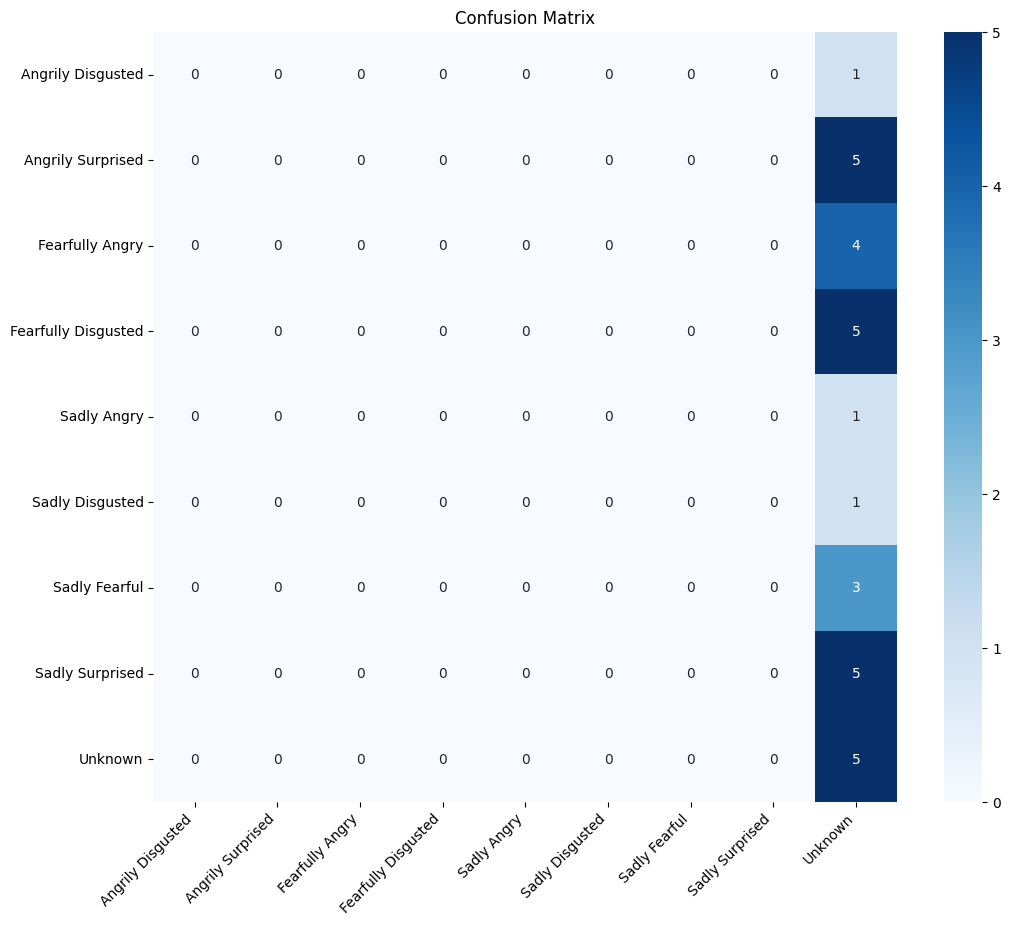

In [31]:
# ==========================================
# METRICS & EVALUATION
# ==========================================
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os

# Config
EMOTION_MAP = {
    1: 'Happily Surprised', 2: 'Happily Disgusted', 3: 'Sadly Fearful',
    4: 'Sadly Angry', 5: 'Sadly Surprised', 6: 'Sadly Disgusted',
    7: 'Fearfully Angry', 8: 'Fearfully Surprised', 9: 'Fearfully Disgusted',
    10: 'Angrily Surprised', 11: 'Angrily Disgusted', 12: 'Disgustedly Surprised',
    13: 'Happily Fearful', 14: 'Happily Sad'
}

y_true = []
y_pred = []
explanations = []

print("🚀 Running Inference on Test Batch...")
# Ensure test_df is loaded (from previous steps)
if 'test_df' not in locals():
    print("⚠️ Please run the 'Load Test Data' cell first!")
else:
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        # Load Image
        path = os.path.join(DATA_DIR, row['f'])
        if not os.path.exists(path): path = path.replace(".jpg", "_aligned.jpg")
        if not os.path.exists(path): continue
        
        # Predict
        image = Image.open(path).convert("RGB")
        messages = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": "Classify the compound emotion."}]}]
        inputs = tokenizer(image, tokenizer.apply_chat_template(messages, add_generation_prompt=True), return_tensors="pt").to("cuda")
        
        with torch.no_grad():
            # This works now because we are in Fast Mode
            out = model.generate(**inputs, max_new_tokens=64, temperature=0.1)
        
        pred_text = tokenizer.decode(out[0], skip_special_tokens=True).split("assistant")[-1].strip()
        explanations.append(pred_text)
        
        # Parse Label
        detected = "Unknown"
        for name in EMOTION_MAP.values():
            if name.lower() in pred_text.lower():
                detected = name
                break
        
        y_pred.append(detected)
        y_true.append(EMOTION_MAP.get(row['lbl'], "Unknown"))

    # Results
    print(f"\n✅ Accuracy: {accuracy_score(y_true, y_pred):.2%}")

    # Confusion Matrix
    labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [32]:
# Construct References (What the model SHOULD have said)
references = []
AU_NAMES = {'1': 'Inner Brow', '2': 'Outer Brow', '4': 'Brow Lowerer', '12': 'Lip Corner', '25': 'Lips Part'}

for _, row in test_df.iterrows():
    emo = EMOTION_MAP.get(row['lbl'], "Unknown")
    aus = au_db.get(row['f'], [])
    au_text = ", ".join([f"{AU_NAMES.get(a, 'AU'+a)}" for a in aus])
    ref = f"The expression is {emo}. I observe: {au_text}."
    references.append(ref)

# Compute Scores
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

b_score = bleu.compute(predictions=explanations, references=[[r] for r in references])
r_score = rouge.compute(predictions=explanations, references=references)

print("📝 Text Quality Metrics:")
print(f"BLEU Score: {b_score['bleu']:.4f}")
print(f"ROUGE-L: {r_score['rougeL']:.4f}")

📝 Text Quality Metrics:
BLEU Score: 0.0000
ROUGE-L: 0.1448


In [33]:
print("🕵️ Faithfulness Analysis...")

total_mentioned = 0
correct_mentioned = 0

for i, pred_text in enumerate(explanations):
    row = test_df.iloc[i]
    true_aus = au_db.get(row['f'], [])
    
    # Simple check: Does the prediction mention the correct AU IDs?
    # (In a real app, you would parse the AU names, but checking IDs/keywords is a good proxy)
    hits = 0
    possible_hits = 0
    
    for au_id in true_aus:
        au_name = AU_NAMES.get(au_id, "")
        # Check if the AU name appears in the model's output
        if au_name and au_name.lower() in pred_text.lower():
            hits += 1
        possible_hits += 1
        
    if possible_hits > 0:
        correct_mentioned += hits
        total_mentioned += possible_hits

faithfulness = correct_mentioned / total_mentioned if total_mentioned > 0 else 0
print(f"✅ Faithfulness Score: {faithfulness:.2%} (Percentage of Ground Truth AUs correctly identified in text)")

🕵️ Faithfulness Analysis...
✅ Faithfulness Score: 0.00% (Percentage of Ground Truth AUs correctly identified in text)
